In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from gym_power_trading.envs import PowerTradingEnv
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7



In [2]:
file_name = r"C:\Users\Andrew Deur\Documents\NYU\DS-GA 3001 Reinforcement Learning\3001-RL-Grid-Battery-Management-Agent\data\AEP_PSGC1_AMP_dart_Oct20.h5"
df = pd.read_hdf(file_name)
df.head()

RT_LMP  DA_LMP
MARKET_DAY NODE          TYPE    VALUE HourEnding                
2020-10-01 AEP.PSGC1.AMP Gennode LMP   1            10.02   14.33
                                       2            12.51   13.09
                                       3            12.79   12.96
                                       4            12.53   13.62
                                       5            13.43   14.49

## 24-hours worth of Observations (Current Price, Day Ahead Price, Price Difference, Battery State of Charge, Battery Avg Energy Price)

In [36]:
window = 10
# Offset by 10 b/c DA prices look 10 ticks into future
env = PowerTradingEnv(df=df, window_size=window, frame_bound=(window, len(df) - 10)) 
obs = env.reset()
for _ in tqdm(range(len(df)-10)):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    if truncated:
        obs = env.reset()

100%|██████████| 30662/30662 [00:00<00:00, 37383.47it/s]


In [4]:
window = 10
venv = make_vec_env(lambda: PowerTradingEnv(df=df, window_size=window, frame_bound=(window, len(df) - 10 - 3000)), n_envs=16) # Leave last 3,000 ticks for Test

### PPO Agent (1,000,000 Iterations) w/o Normalizing Observations

Rewards: 

    - Profit From Discharge (Current Price - Avg Price) * Charge Sold
    - Charginge at price below its avg charge price

Penalty:

    - Overcharging (-1)

In [38]:
%%time
PPO_power_model_5MM = PPO('MlpPolicy', venv, device='cpu')
PPO_power_model_5MM.learn(total_timesteps=5000000, progress_bar=True)

Output()

CPU times: total: 4h 35min 5s
Wall time: 42min 46s


In [6]:
last_index = len(df) - 10
start_index = last_index - 3000
env2 = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env2.reset()
obs = obs[0]

for i in range(last_index - start_index):
    action, states = PPO_power_model_5MM.predict(obs)
    obs, rewards, term, trunc, info = env2.step(action)
    if term or trunc:
        history = env2.history
        pos = env2.render_all(title="Agent Positions @ 5,000,000 Training Iterations", xlim=(1100, 1500))
        env2.reset()

plt.plot()

NameError: name 'PPO_power_model_5MM' is not defined

In [ ]:
mean_reward, reward_std = evaluate_policy(PPO_power_model_5MM, env2, n_eval_episodes=100)
print(f"Mean Reward:{ mean_reward:,.2f}\nReward std: {reward_std:,.2f}")

Mean Reward:68,642.01
Reward std: 2,840.68


DEBUG:Comm:handle_msg[aebdf7094ee1464bafc27303fa10d683]({'header': {'date': datetime.datetime(2024, 4, 23, 6, 21, 7, 626000, tzinfo=tzutc()), 'msg_id': 'd6d04d0a-9c20-44a2-a2a4-40701f279474', 'msg_type': 'comm_msg', 'session': 'c2251bd2-f3b2-4382-bea5-6e0674eb8a71', 'username': '8b9b45a1-51d8-4068-a1c4-8bba7a0a53e0', 'version': '5.2'}, 'msg_id': 'd6d04d0a-9c20-44a2-a2a4-40701f279474', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'aebdf7094ee1464bafc27303fa10d683', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '\x1b 100%\x1b \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b5,013,408/5,000,000 \x1b [ \x1b0:42:31\x1b < \x1b0:00:00\x1b , \x1b2,925 it/s\x1b ]\n', 'text/html': '<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,\'DejaVu Sans Mono\',consolas,\'Courier New\',monospace"><span style="color: #800080; text-decoration-color: #800080"> 100

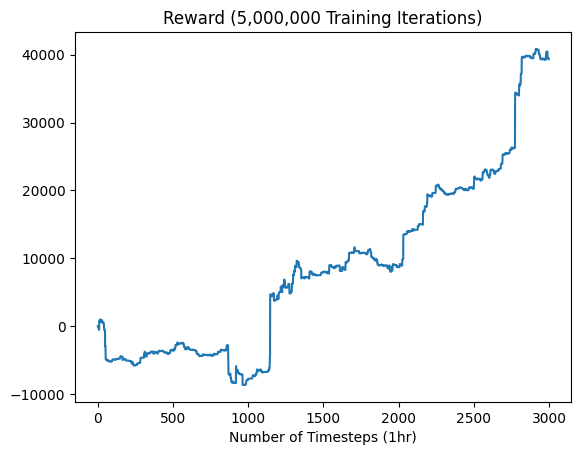

In [42]:
plt.plot(history['total_reward'])
plt.title("Reward (5,000,000 Training Iterations)")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

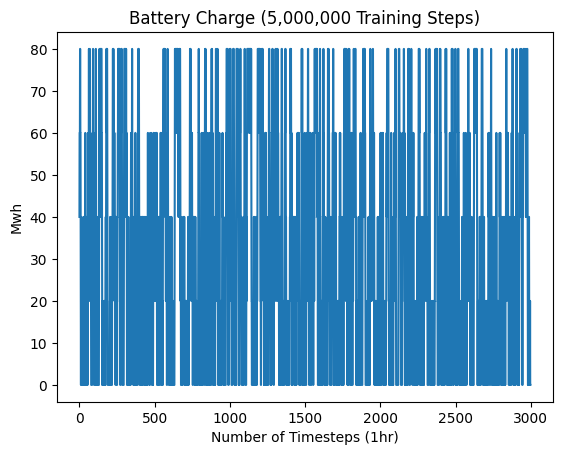

In [43]:
### PPO 10,000 Steps on Sinusoid
plt.plot(history['battery_charge'])
plt.title("Battery Charge (5,000,000 Training Steps)")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

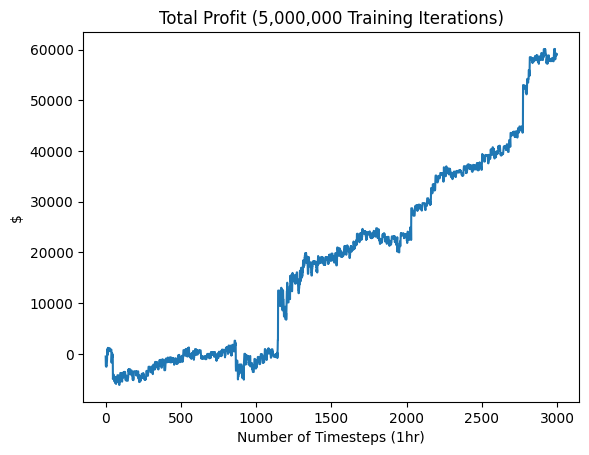

In [44]:
plt.plot(history['total_profit'])
plt.title("Total Profit (5,000,000 Training Iterations)")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

In [50]:
PPO_power_model_5MM.save('PPO_power_trading_5MM_unnormalized_features')

## Normalize Observations 

(Battery Capacity 0-> 1, Battery Price Normalied by Window MA, )

In [5]:
%%time
PPO_power_model_5MM_norm = PPO('MlpPolicy', venv, device='cpu')
PPO_power_model_5MM_norm.learn(total_timesteps=5000000, progress_bar=True)

Output()

CPU times: total: 4h 10min 44s
Wall time: 45min 39s


DEBUG:Comm:handle_msg[400a8bd963264e0b97b1cd889ca54cd0]({'header': {'date': datetime.datetime(2024, 4, 23, 15, 50, 46, 352000, tzinfo=tzutc()), 'msg_id': '1491db06-3b6b-43ab-a1e4-4cfc56fde641', 'msg_type': 'comm_msg', 'session': 'c2251bd2-f3b2-4382-bea5-6e0674eb8a71', 'username': '8b9b45a1-51d8-4068-a1c4-8bba7a0a53e0', 'version': '5.2'}, 'msg_id': '1491db06-3b6b-43ab-a1e4-4cfc56fde641', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '400a8bd963264e0b97b1cd889ca54cd0', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '\x1b 100%\x1b \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b5,012,400/5,000,000 \x1b [ \x1b0:45:23\x1b < \x1b0:00:00\x1b , \x1b2,854 it/s\x1b ]\n', 'text/html': '<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,\'DejaVu Sans Mono\',consolas,\'Courier New\',monospace"><span style="color: #800080; text-decoration-color: #800080"> 1

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Andrew Deur\\anaconda3\\envs\\rl_project\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Andrew Deur\\anaconda3\\envs\\rl_project\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Andrew 

[]

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Andrew Deur\\anaconda3\\envs\\rl_project\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Andrew Deur\\anaconda3\\envs\\rl_project\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Andrew Deur\\anaconda3\\envs\\rl_project\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretc

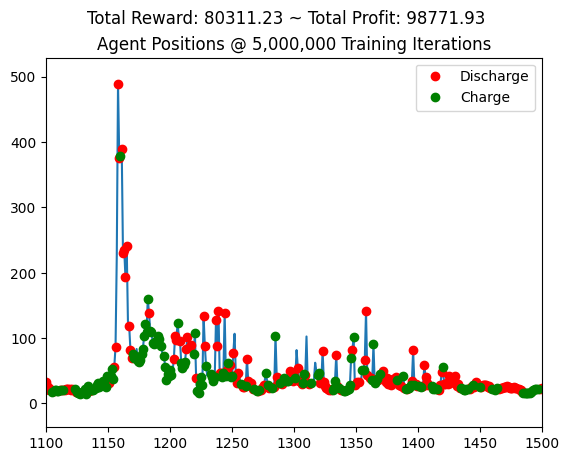

In [10]:
last_index = len(df) - 10
start_index = last_index - 3000
env2 = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env2.reset()
obs = obs[0]

for i in range(last_index - start_index):
    action, states = PPO_power_model_5MM_norm.predict(obs)
    obs, rewards, term, trunc, info = env2.step(action)
    if term or trunc:
        history = env2.history
        pos = env2.render_all(title="Agent Positions @ 5,000,000 Training Iterations", xlim=(1100, 1500))
        env2.reset()

plt.plot()

In [11]:
mean_reward, reward_std = evaluate_policy(PPO_power_model_5MM_norm, env2, n_eval_episodes=100)
print(f"Mean Reward:{ mean_reward:,.2f}\nReward std: {reward_std:,.2f}")

c:\Users\Andrew Deur\anaconda3\envs\rl_project\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean Reward:121,472.21
Reward std: 0.00


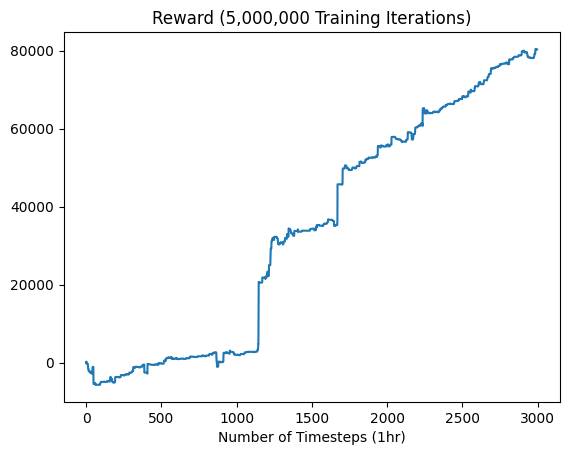

In [12]:
plt.plot(history['total_reward'])
plt.title("Reward (5,000,000 Training Iterations)")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

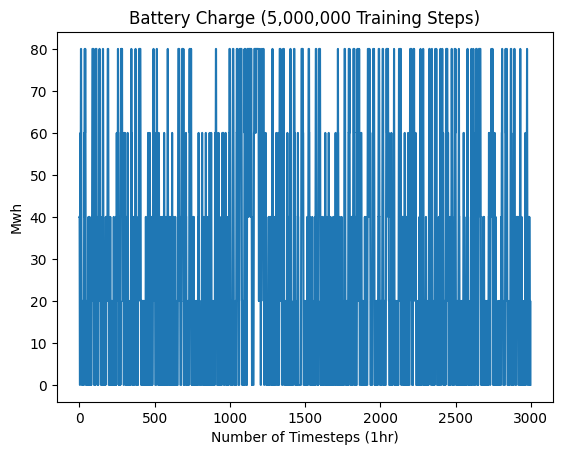

In [13]:
### PPO 10,000 Steps on Sinusoid
plt.plot(history['battery_charge'])
plt.title("Battery Charge (5,000,000 Training Steps)")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

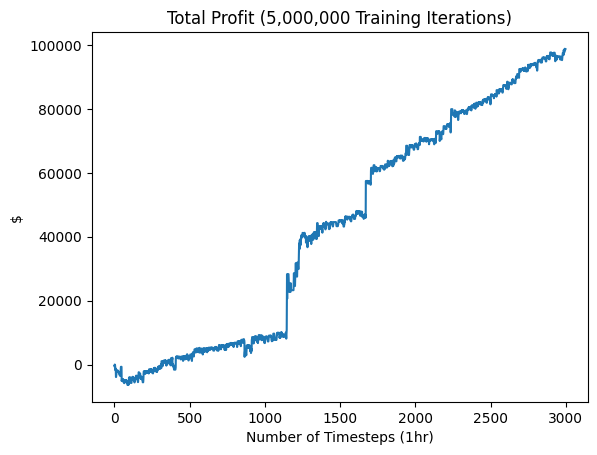

In [14]:
plt.plot(history['total_profit'])
plt.title("Total Profit (5,000,000 Training Iterations)")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

In [15]:
PPO_power_model_5MM_norm.save('PPO_power_trading_5MM_normalized_features')